<p style="align: center;"><img align=center src="https://drive.google.com/uc?export=view&id=1I8kDikouqpH4hf7JBiSYAeNT2IO52T-T" width=600 height=480/></p>
<h3 style="text-align: center;"><b>Школа глубокого обучения ФПМИ МФТИ</b></h3>

<h3 style="text-align: center;"><b>Домашнее задание. Generative adversarial networks</b></h3>



В этом домашнем задании вы обучите GAN генерировать лица людей и посмотрите на то, как можно оценивать качество генерации

In [1]:
import os
from torch.utils.data import DataLoader
from torchvision.datasets import ImageFolder
import torchvision.transforms as tt
import torch
import torch.nn as nn
import cv2
from tqdm.notebook import tqdm
from torchvision.utils import save_image
from torchvision.utils import make_grid
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

sns.set(style='darkgrid', font_scale=1.2)

D:\Anaconda\envs\pydml\lib\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## Часть 1. Подготовка данных (1 балл)

В качестве обучающей выборки возьмем часть датасета [Flickr Faces](https://github.com/NVlabs/ffhq-dataset), который содержит изображения лиц людей в высоком разрешении (1024х1024). Оригинальный датасет очень большой, поэтому мы возьмем его часть. Скачать датасет можно [здесь](https://www.kaggle.com/datasets/tommykamaz/faces-dataset-small?resource=download-directory) и  [здесь](https://drive.google.com/drive/folders/14H7LQWzd09SaM11oLfGtd455sWH2rmRW?usp=share_link)

Давайте загрузим наши изображения. Напишите функцию, которая строит DataLoader для изображений, при этом меняя их размер до нужного значения (размер 1024 слишком большой, поэтому мы рекомендуем взять размер 128 либо немного больше)

In [2]:
#Для обучения я использовал датасет с 70000 лиц (вместо урезанного), ссылку на который я нашел в конфе с помощью по дз 
#Ссылка на датасет: https://drive.google.com/file/d/1EpK47gr2zKl4UF0RJ2oGVi7AgzHsYjYu/view
DATA_DIR = 'D:\\Python\\Autoencoder\\Deep learning school\\Homework_8\\faces'
stats = (0.5, 0.5, 0.5), (0.5, 0.5, 0.5)

In [3]:
#Запишем функцию для генерацию даталодера + возьмем несколько функций из семинара
def get_dataloader(image_size, batch_size, directory):
  """
  Builds dataloader for training data.
  Use tt.Compose and tt.Resize for transformations
  :param image_size: height and wdith of the image
  :param batch_size: batch_size of the dataloader
  :returns: DataLoader object 
  """
  train_ds = ImageFolder(directory, transform=tt.Compose([
    tt.Resize(image_size),
    tt.CenterCrop(image_size),
    tt.ToTensor(),
    tt.Normalize(*stats)]))  
  return DataLoader(train_ds, batch_size, shuffle=True, num_workers=0, pin_memory=True)

In [4]:
def denorm(img_tensors):
    return img_tensors * stats[1][0] + stats[0][0]

In [5]:
def show_images(images, nmax=64):
    fig, ax = plt.subplots(figsize=(8, 8))
    ax.set_xticks([]); ax.set_yticks([])
    ax.imshow(make_grid(denorm(images.detach()[:nmax]), nrow=8).permute(1, 2, 0))

def show_batch(dl, nmax=64):
    for images, _ in dl:
        show_images(images, nmax)
        break

In [6]:
def to_device(data, device):
    """Move tensor(s) to chosen device"""
    if isinstance(data, (list,tuple)):
        return [to_device(x, device) for x in data]
    return data.to(device, non_blocking=True)

class DeviceDataLoader():
    """Wrap a dataloader to move data to a device"""
    def __init__(self, dl, device):
        self.dl = dl
        self.device = device
        
    def __iter__(self):
        """Yield a batch of data after moving it to device"""
        for b in self.dl: 
            yield to_device(b, self.device)

    def __len__(self):
        """Number of batches"""
        return len(self.dl)

In [7]:
image_size = 128
batch_size = 128
train_dl = get_dataloader(image_size, batch_size, DATA_DIR)

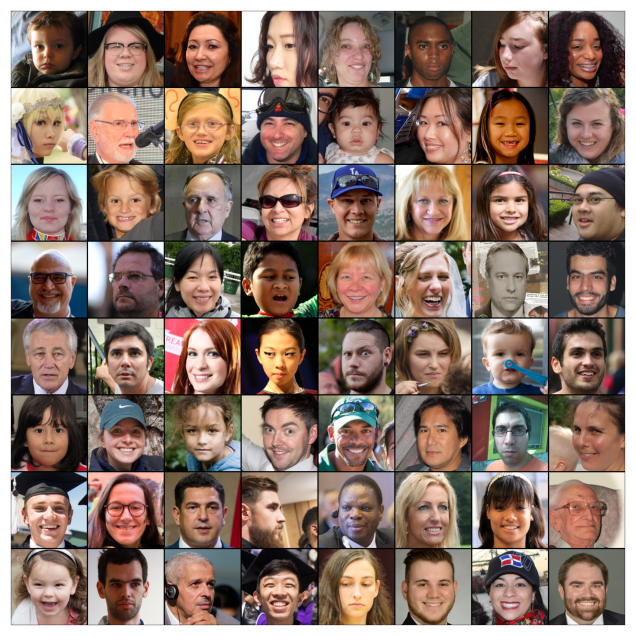

In [8]:
#Посмотрим пример из 64 изображений датасета
show_batch(train_dl)

In [9]:
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
device

device(type='cpu')

In [10]:
train_dl = DeviceDataLoader(train_dl, device)

## Часть 2. Построение и обучение модели (2 балла)

Сконструируйте генератор и дискриминатор. Помните, что:
* дискриминатор принимает на вход изображение (тензор размера `3 x image_size x image_size`) и выдает вероятность того, что изображение настоящее (тензор размера 1)

* генератор принимает на вход тензор шумов размера `latent_size x 1 x 1` и генерирует изображение размера `3 x image_size x image_size`

In [11]:
discriminator = nn.Sequential(
    # in: 3 x 128 x 128

    nn.Conv2d(3, 64, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(64),
    nn.LeakyReLU(0.2, inplace=True),
    # out: 64 x 64 x 64

    nn.Conv2d(64, 128, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(128),
    nn.LeakyReLU(0.2, inplace=True),
    # out: 128 x 32 x 32

    nn.Conv2d(128, 256, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(256),
    nn.LeakyReLU(0.2, inplace=True),
    # out: 256 x 16 x 16

    nn.Conv2d(256, 256, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(256),
    nn.LeakyReLU(0.2, inplace=True),
    # out: 512 x 8 x 8
    
    nn.Conv2d(256, 512, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(512),
    nn.LeakyReLU(0.2, inplace=True),
    #out: 512 x 4 x 4

    nn.Conv2d(512, 1, kernel_size=4, stride=1, padding=0, bias=False),
    # out: 1 x 1 x 1

    nn.Flatten(),
    nn.Sigmoid())
discriminator = discriminator.to(device)

In [12]:
latent_size = 128 # choose latent size
generator = nn.Sequential(
    # in: latent_size x 1 x 1
    nn.ConvTranspose2d(latent_size, 512, kernel_size=4, stride=1, padding=0, bias=False),
    nn.BatchNorm2d(512),
    nn.ReLU(True),
    # out: 512 x 4 x 4

    nn.ConvTranspose2d(512, 256, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(256),
    nn.ReLU(True),
    # out: 512 x 8 x 8

    nn.ConvTranspose2d(256, 256, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(256),
    nn.ReLU(True),
    # out: 256 x 16 x 16

    nn.ConvTranspose2d(256, 128, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(128),
    nn.ReLU(True),
    # out: 128 x 32 x 32

    nn.ConvTranspose2d(128, 64, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(64),
    nn.ReLU(True),
    # out: 64 x 64 x 64

    nn.ConvTranspose2d(64, 3, kernel_size=4, stride=2, padding=1, bias=False),
    nn.Tanh()
    # out: 3 x 128 x 128
)
generator = generator.to(device)

Перейдем теперь к обучению нашего GANа. Алгоритм обучения следующий:
1. Учим дискриминатор:
  * берем реальные изображения и присваиваем им метку 1
  * генерируем изображения генератором и присваиваем им метку 0
  * обучаем классификатор на два класса

2. Учим генератор:
  * генерируем изображения генератором и присваиваем им метку 0
  * предсказываем дискриминаторором, реальное это изображение или нет


В качестве функции потерь берем бинарную кросс-энтропию

In [13]:
lr = 0.0002
epochs = 40
model = {
    "discriminator": discriminator,
    "generator": generator
}

criterion = {
    "discriminator": nn.BCELoss(),
    "generator": nn.BCELoss()
}
fixed_latent = torch.randn(batch_size, latent_size, 1, 1, device=device)#Использовался для контроля во время обучения

In [14]:
from IPython.display import clear_output
def fit(model, criterion, epochs, lr, start_idx=1):
    model["discriminator"].train()
    model["generator"].train()
    torch.cuda.empty_cache()
    
    # Losses & scores
    losses_g = []
    losses_d = []
    real_scores = []
    fake_scores = []
    
    # Create optimizers
    optimizer = {
        "discriminator": torch.optim.Adam(model["discriminator"].parameters(), 
                                          lr=lr, betas=(0.5, 0.999)),
        "generator": torch.optim.Adam(model["generator"].parameters(),
                                      lr=lr, betas=(0.5, 0.999))
    }
    
    for epoch in range(epochs):
        
        loss_d_per_epoch = []
        loss_g_per_epoch = []
        real_score_per_epoch = []
        fake_score_per_epoch = []
        for real_images, _ in tqdm(train_dl):
            # Train discriminator
            # Clear discriminator gradients
            optimizer["discriminator"].zero_grad()

            # Pass real images through discriminator
            real_preds = model["discriminator"](real_images)
            real_targets = torch.ones(real_images.size(0), 1, device=device) - torch.rand(real_images.size(0),1, device=device)*0.15
            real_loss = criterion["discriminator"](real_preds, real_targets)
            cur_real_score = torch.mean(real_preds).item()
            
            # Generate fake images
            latent = torch.randn(batch_size, latent_size, 1, 1, device=device)
            fake_images = model["generator"](latent)

            # Pass fake images through discriminator
            fake_targets = torch.zeros(fake_images.size(0), 1, device=device) + torch.rand(fake_images.size(0),1, device=device)*0.15
            fake_preds = model["discriminator"](fake_images)
            fake_loss = criterion["discriminator"](fake_preds, fake_targets)
            cur_fake_score = torch.mean(fake_preds).item()

            real_score_per_epoch.append(cur_real_score)
            fake_score_per_epoch.append(cur_fake_score)

            # Update discriminator weights
            loss_d = real_loss + fake_loss
            loss_d.backward()
            optimizer["discriminator"].step()
            loss_d_per_epoch.append(loss_d.item())


            # Train generator
            # Clear generator gradients
            optimizer["generator"].zero_grad()
            
            # Generate fake images
            latent = torch.randn(batch_size, latent_size, 1, 1, device=device)
            fake_images = model["generator"](latent)
            
            # Try to fool the discriminator
            preds = model["discriminator"](fake_images)
            targets = torch.ones(batch_size, 1, device=device)
            loss_g = criterion["generator"](preds, targets)
            
            # Update generator weights
            loss_g.backward()
            optimizer["generator"].step()
            loss_g_per_epoch.append(loss_g.item())
            
        # Record losses & scores
        losses_g.append(np.mean(loss_g_per_epoch))
        losses_d.append(np.mean(loss_d_per_epoch))
        real_scores.append(np.mean(real_score_per_epoch))
        fake_scores.append(np.mean(fake_score_per_epoch))
        
        # Log losses & scores (last batch)
        clear_output(True)
        print("Epoch [{}/{}], loss_g: {:.4f}, loss_d: {:.4f}, real_score: {:.4f}, fake_score: {:.4f}".format(
            epoch+1, epochs, 
            losses_g[-1], losses_d[-1], real_scores[-1], fake_scores[-1]))
        randRes = generator(fixed_latent).detach().to('cpu')
        show_images(randRes)
        plt.show()
  
    return losses_g, losses_d, real_scores, fake_scores

In [15]:
#Я обучал модель на kaggle с вышеуказанными параметрами, после чего сохранил веса моделей, обучение шло около 5 часов
#history = fit(model, criterion, epochs, lr)

In [16]:
#Загрузим обученные веса и массив с лоссами и скорами
generator.load_state_dict(torch.load('gen_state.pth', map_location=torch.device('cpu')))
history = np.load('history.npy')
#Веса дискриминатора сохранены, но н аданный момент не нужны

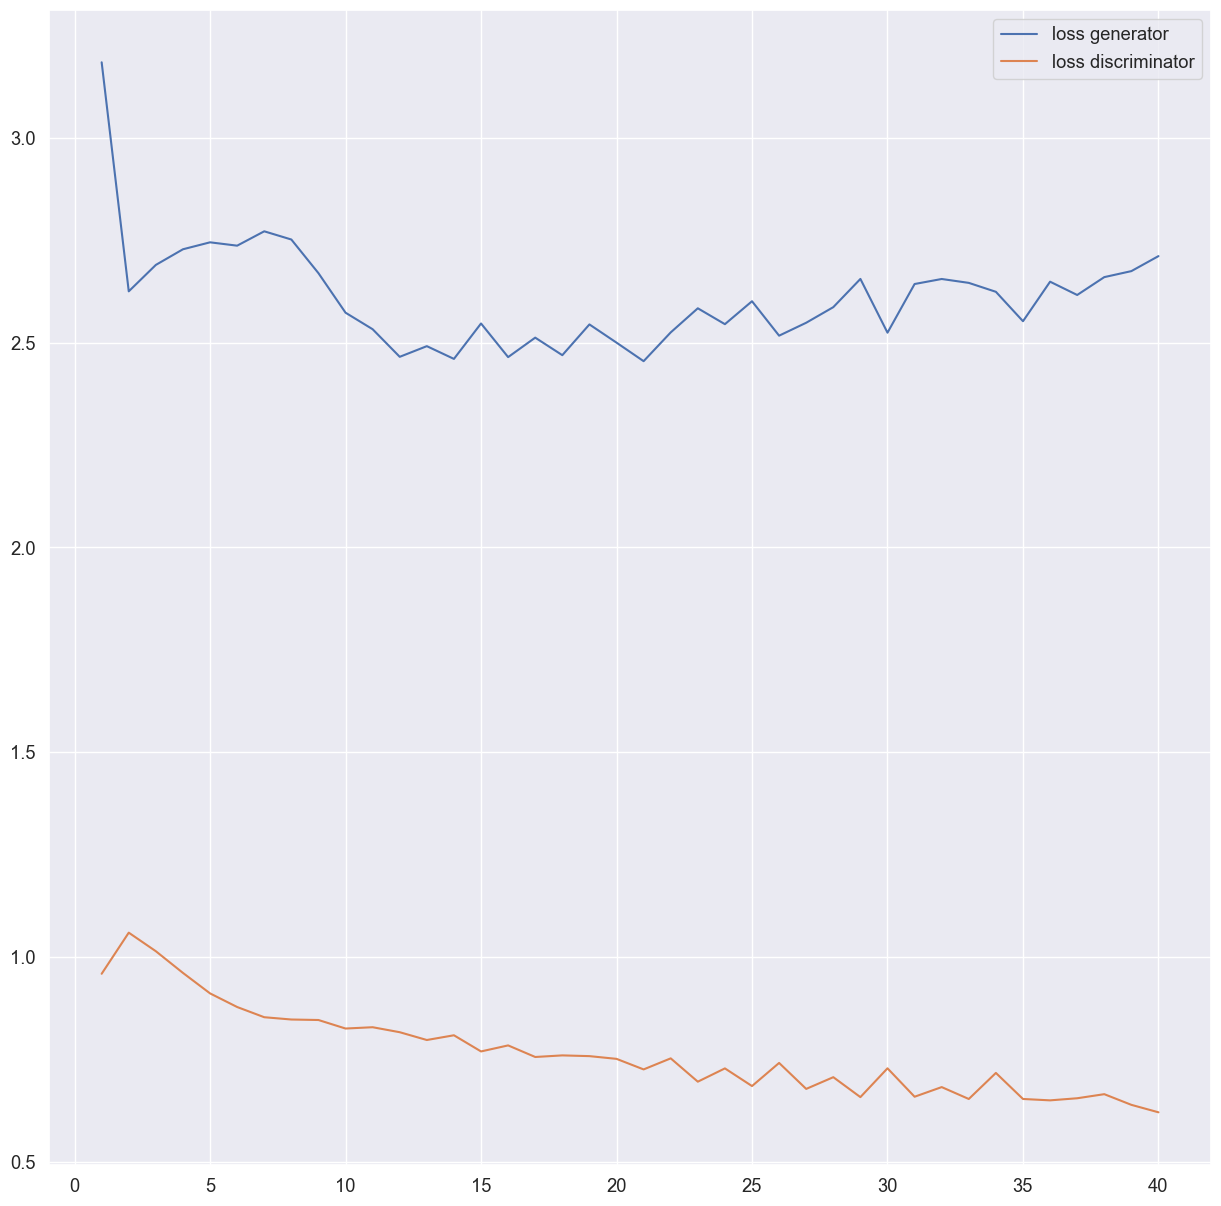

In [17]:
#Графики лоссов при обучении
epochsPlot = list( range(1, epochs+1))
plt.figure(figsize=(15,15))
plt.plot(epochsPlot, history[0], label='loss generator')
plt.plot(epochsPlot, history[1], label='loss discriminator')
plt.legend()
plt.show()

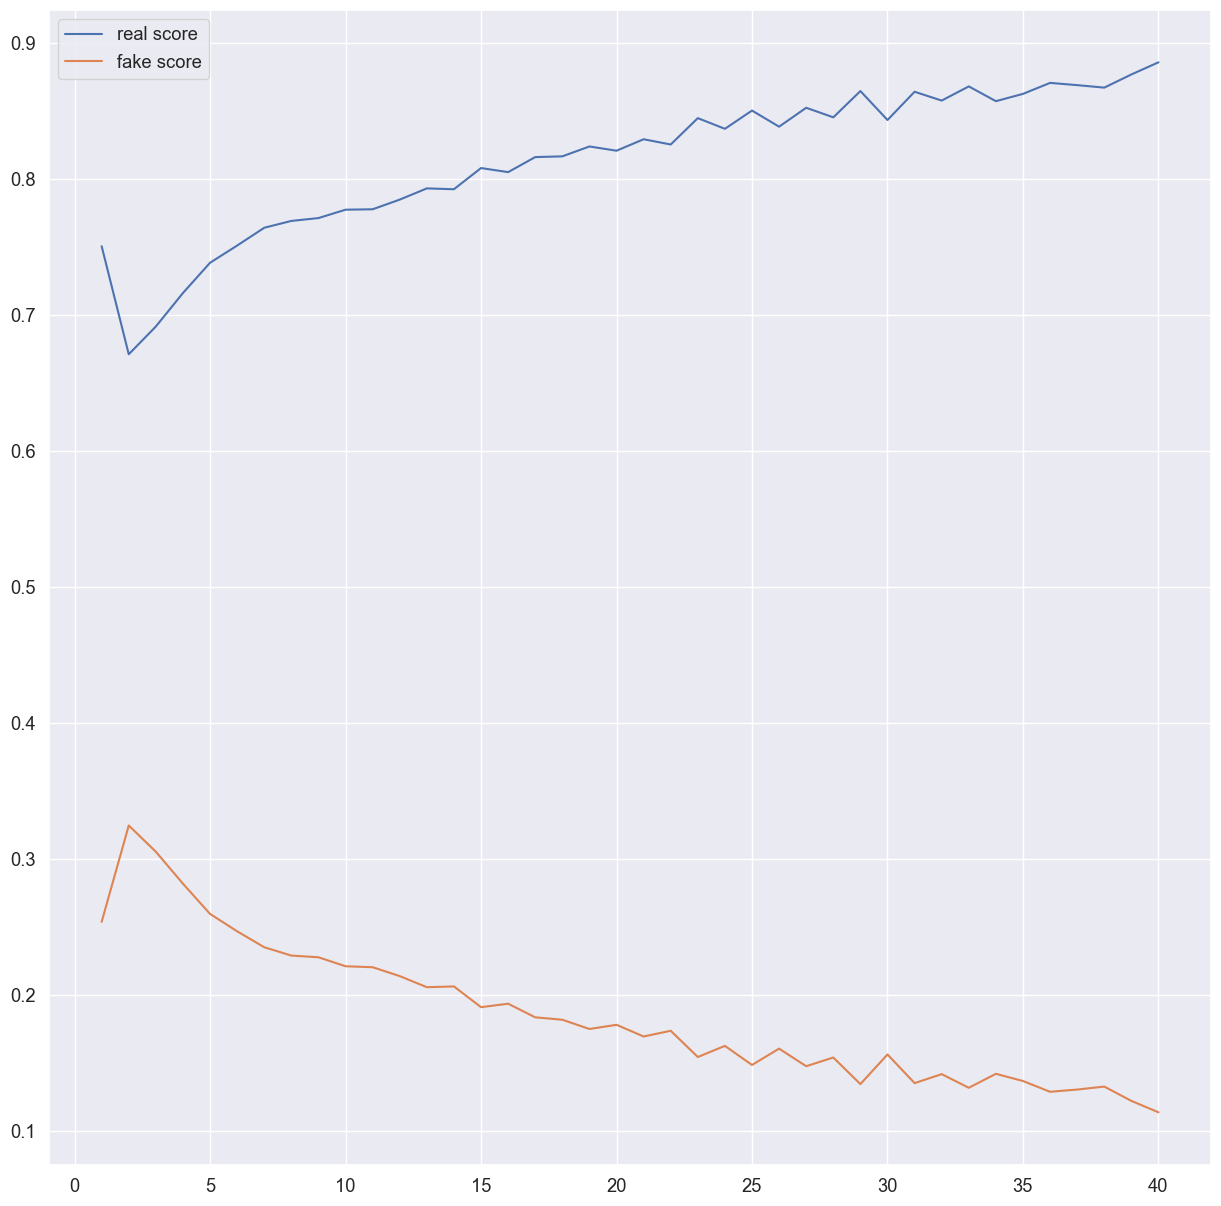

In [18]:
#Графики скоров при обучении
epochsPlot = list( range(1, epochs+1))
plt.figure(figsize=(15,15))
plt.plot(epochsPlot, history[2], label='real score')
plt.plot(epochsPlot, history[3], label='fake score')
plt.legend()
plt.show()

Постройте графики лосса для генератора и дискриминатора. Что вы можете сказать про эти графики?

## Часть 3. Генерация изображений (1 балл)

Теперь давайте оценим качество получившихся изображений. Напишите функцию, которая выводит изображения, сгенерированные нашим генератором

In [19]:
n_images = 64
with torch.no_grad():
    generator.eval()
    fixed_latent = torch.randn(n_images, latent_size, 1, 1, device=device)
    fake_images = model["generator"](fixed_latent).to('cpu')

In [20]:
#Продублирую функцию написанную выше
def show_images(images, nmax=64):
    fig, ax = plt.subplots(figsize=(8, 8))
    ax.set_xticks([]); ax.set_yticks([])
    ax.imshow(make_grid(denorm(images.detach()[:nmax]), nrow=8).permute(1, 2, 0))

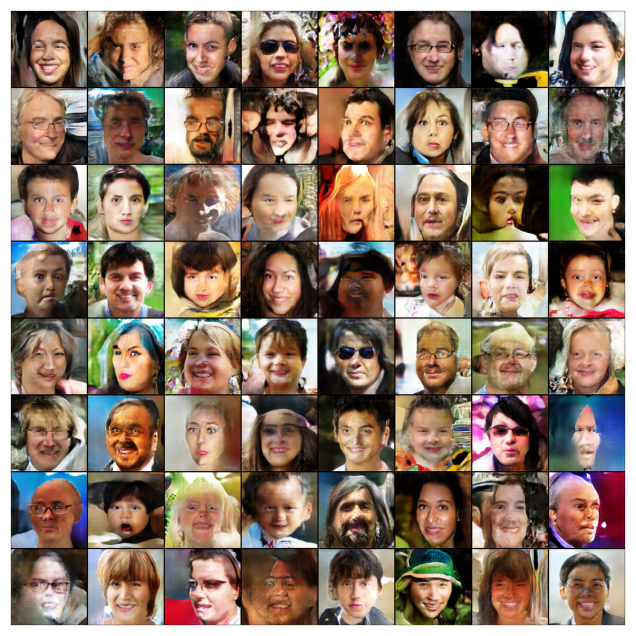

In [21]:
show_images(fake_images)

Как вам качество получившихся изображений?

## Часть 4. Leave-one-out-1-NN classifier accuracy (6 баллов)

### 4.1. Подсчет accuracy (4 балла)

Не всегда бывает удобно оценивать качество сгенерированных картинок глазами. В качестве альтернативы вам предлагается реализовать следующий подход:
  * Сгенерировать столько же фейковых изображений, сколько есть настоящих в обучающей выборке. Присвоить фейковым метку класса 0, настоящим – 1.
  * Построить leave-one-out оценку: обучить 1NN Classifier (`sklearn.neighbors.KNeighborsClassifier(n_neighbors=1)`) предсказывать класс на всех объектах, кроме одного, проверить качество (accuracy) на оставшемся объекте. В этом вам поможет `sklearn.model_selection.LeaveOneOut`

In [22]:
#Для оценки качества используем малый датасет, который является выборкой датасета из 70к фотографий
ACCURACY_DIR = 'faces_dataset_small'
accuracy_loader = get_dataloader(image_size, batch_size, ACCURACY_DIR)

In [23]:
real_images = torch.ones(1,3,128,128, dtype=torch.float32)
for batch, _ in accuracy_loader:
    real_images = torch.cat([real_images, batch], dim=0)
real_images = real_images[1:]
real_images = np.array(real_images)

In [24]:
real_labels = np.ones(real_images.shape[0])

In [25]:
with torch.no_grad():
    generator.eval()
    fix_latent = torch.randn(real_images.shape[0], latent_size, 1, 1, device=device)
    fake_img = model["generator"](fix_latent).to('cpu')
fake_img = np.array(fake_img)

In [26]:
fake_labels = np.zeros(fake_img.shape[0])

In [34]:
score_data = np.concatenate([real_images, fake_img], axis=0)
score_data_reshaped = score_data.reshape(score_data.shape[0], 3*128*128)
score_labels = np.concatenate([real_labels, fake_labels], axis=0)

In [35]:
from sklearn.model_selection import LeaveOneOut
from sklearn.neighbors import  KNeighborsClassifier

In [36]:
nbrs =  KNeighborsClassifier(n_neighbors=1)
loo = LeaveOneOut()

In [38]:
from sklearn.model_selection import cross_val_score
scores = cross_val_score(nbrs, score_data_reshaped, score_labels, cv=loo, scoring='accuracy', verbose=10, n_jobs=-1)

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:   30.4s
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:   33.9s
[Parallel(n_jobs=-1)]: Done  17 tasks      | elapsed:   37.5s
[Parallel(n_jobs=-1)]: Done  26 tasks      | elapsed:   43.5s
[Parallel(n_jobs=-1)]: Done  37 tasks      | elapsed:   49.7s
[Parallel(n_jobs=-1)]: Done  48 tasks      | elapsed:   55.7s
[Parallel(n_jobs=-1)]: Done  61 tasks      | elapsed:  1.0min
[Parallel(n_jobs=-1)]: Done  74 tasks      | elapsed:  1.2min
[Parallel(n_jobs=-1)]: Done  89 tasks      | elapsed:  1.3min
[Parallel(n_jobs=-1)]: Done 104 tasks      | elapsed:  1.4min
[Parallel(n_jobs=-1)]: Done 121 tasks      | elapsed:  1.6min
[Parallel(n_jobs=-1)]: Done 138 tasks      | elapsed:  1.7min
[Parallel(n_jobs=-1)]: Done 157 tasks      | elapsed:  1.8min
[Parallel(n_jobs=-1)]: Done 176 tasks      | elapsed:  2.0min
[Parallel(n_jobs=-1)]: Done 197 tasks      | elapsed:  

In [39]:
scores.mean()

0.6571746738784601

Что вы можете сказать о получившемся результате? Какой accuracy мы хотели бы получить и почему?

Средний скор должен быть близок к 0.5, что означало бы невозможность предсказания отнесения картинки к класу сгенерированных или классу реальных изображений. Это говорит о близости между собой сгенерированных и реальных изображений в Евклидовом пространстве. Ввиду того, что данная модель довольно простая средний скор выходит около 0.66, что достаточно далеко от 1.0 (1.0 свидетельстовал бы о сильной отдаленности реальных и сгенерированных изображений в Евклидовом простанстве). 

### 4.2. Визуализация распределений (2 балла)

Давайте посмотрим на то, насколько похожи распределения настоящих и фейковых изображений. Для этого воспользуйтесь методом, снижающим размерность (к примеру, TSNE) и изобразите на графике разным цветом точки, соответствующие реальным и сгенерированным изображенияи

In [40]:
import numpy as np
from sklearn.manifold import TSNE

data2d = TSNE(n_components=2, learning_rate='auto',
                  init='random').fit_transform(score_data_reshaped)

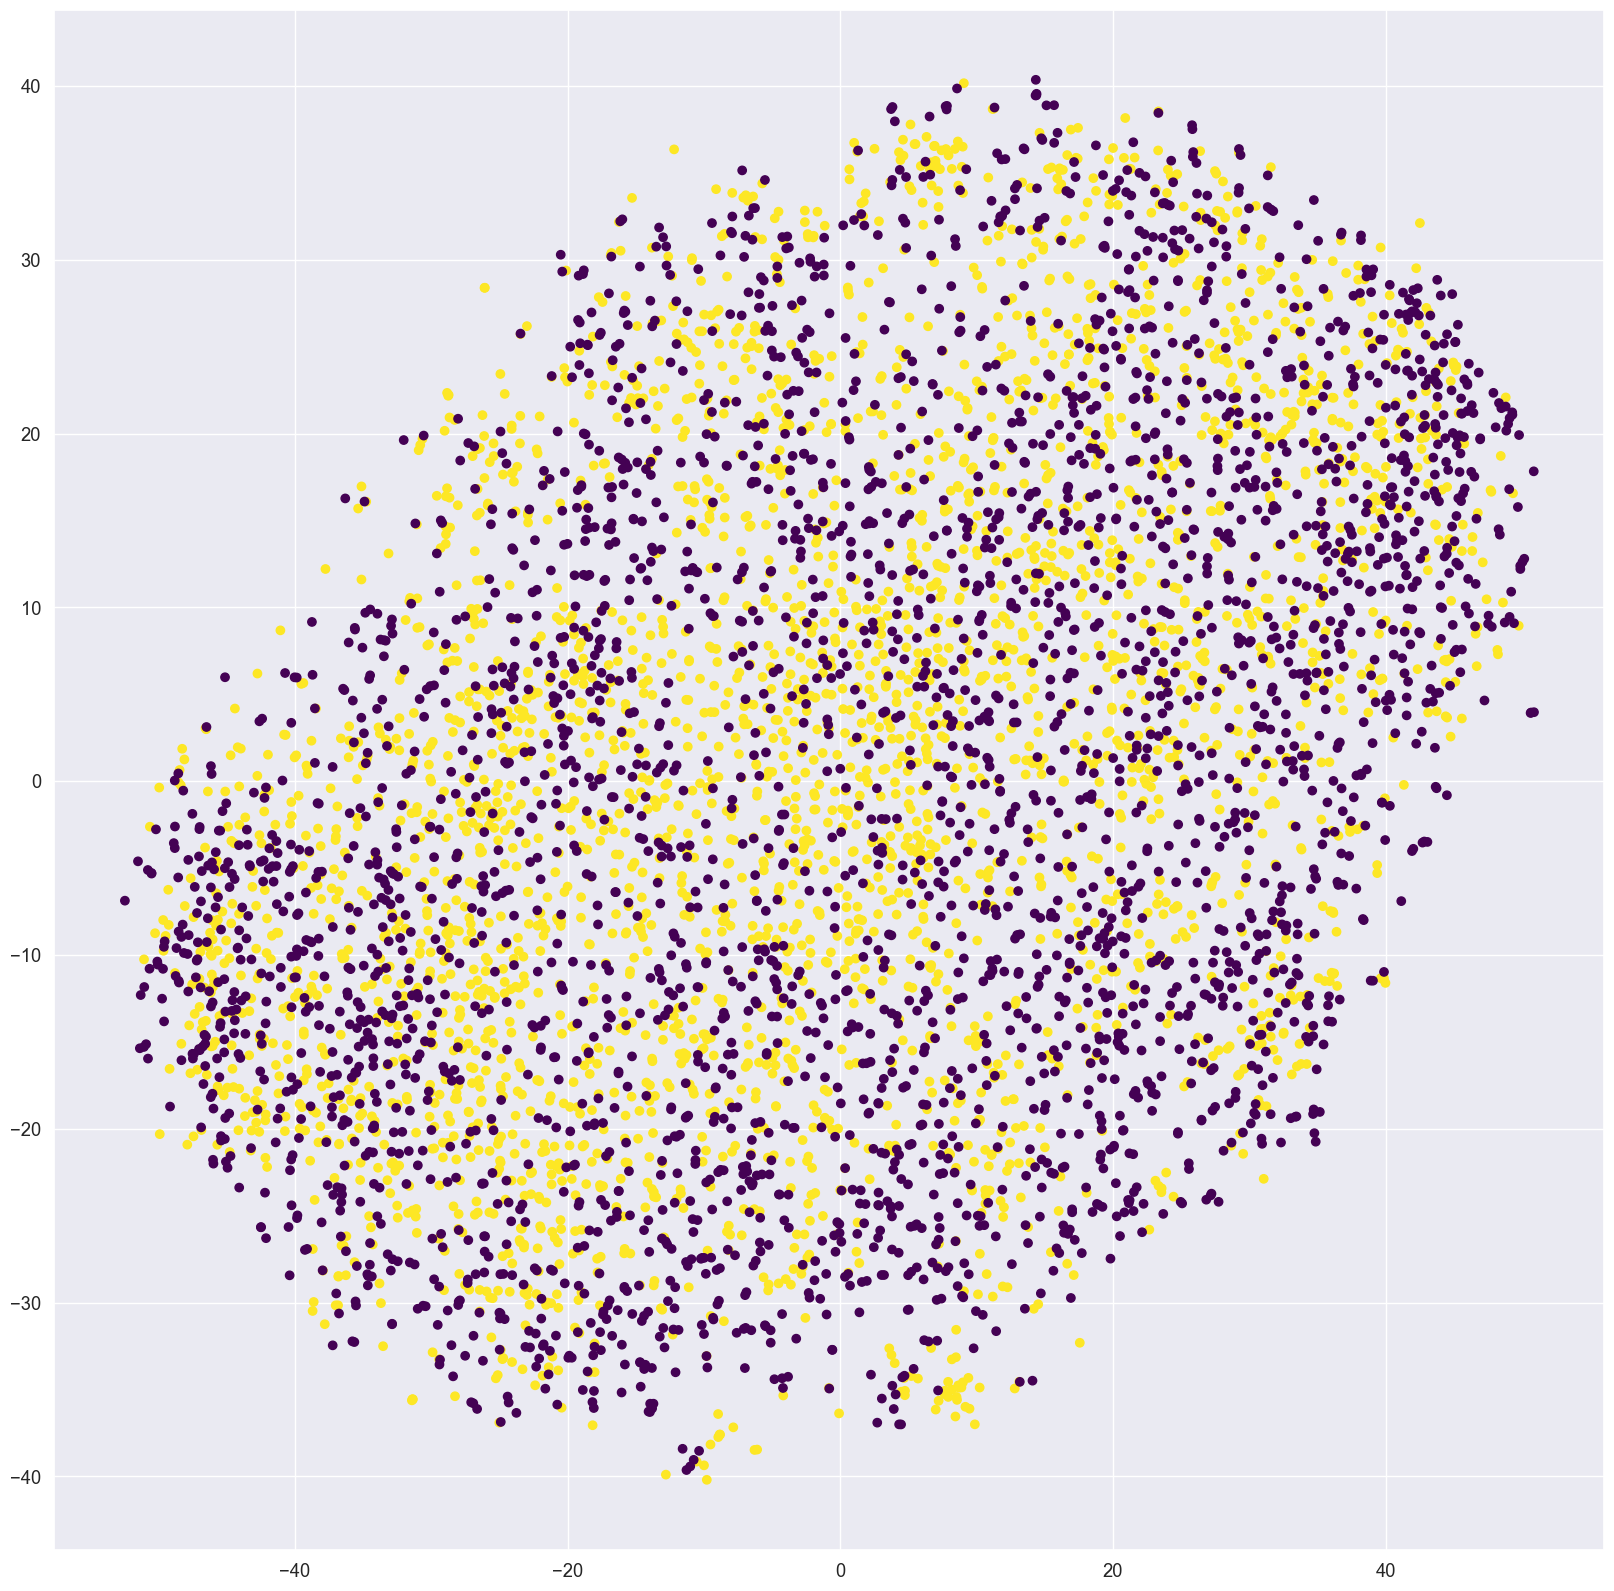

In [43]:
#Ввиду неразделимости распределений точек реальных и сгенерированных изображений легенда точек бессмысленна
dim1, dim2 = data2d[:, 0], data2d[:, 1]
plt.figure(figsize=[20,20])
plt.scatter(dim1, dim2, c=score_labels, cmap = 'viridis');

Прокомментируйте получившийся результат:

По полученному результату видно, что сгенерированные изображения и реальные перемешаны между собой, что означает очень близкое сходство их распределений. Это говорит нам о том, что gan достаточно качественно обучил модель генерировать лица.